## A dataset is provided with sku (store keeping unit) which is a part of an order. 
## Building a model to distribute customers in different categories on the basis of loyalty. 
## The objective is to find out the customer who are loyal.

In [1]:
# Importing important libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler as sc
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
sku=pd.read_csv("assignment1_data.csv", encoding= 'unicode_escape')

### Data Cleaning & Preprocessing

In [3]:
sku.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
sku.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
sku.shape

(541909, 8)

In [6]:
sku.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
sku.duplicated().sum()

5268

In [8]:
# dropping duplicates from the data
sku.drop_duplicates(inplace=True)

In [9]:
sku.shape

(536641, 8)

In [10]:
sku.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,536641,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,536641,4070,85123A,2301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,535187,4223,WHITE HANGING HEART T-LIGHT HOLDER,2357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,536641.0,NaN,NaN,NaN,9.620029,219.130156,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,536641,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,536641.0,NaN,NaN,NaN,4.632656,97.233118,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,401604.0,NaN,NaN,NaN,15281.160818,1714.006089,12346.0,13939.0,15145.0,16784.0,18287.0
Country,536641,38,United Kingdom,490300,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# as observed quantity and unitprice minimum value is negative . That cant be possible so we 
# take only those values which have positive values in our dataframe

In [12]:
sku_new=sku[sku["Quantity"]>0]
sku_new2=sku[sku["UnitPrice"]>0]
new_df=sku_new2

In [13]:
new_df.shape

(534129, 8)

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534129 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    534129 non-null  object 
 1   StockCode    534129 non-null  object 
 2   Description  534129 non-null  object 
 3   Quantity     534129 non-null  int64  
 4   InvoiceDate  534129 non-null  object 
 5   UnitPrice    534129 non-null  float64
 6   CustomerID   401564 non-null  float64
 7   Country      534129 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.7+ MB


In [15]:
new_df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132565
Country             0
dtype: int64

In [16]:
# we drop the missing values rows
new_df.dropna(inplace=True)

In [17]:
new_df.shape

(401564, 8)

In [18]:
new_df.describe()

,Quantity,UnitPrice,CustomerID
count,401564.000000,401564.000000,401564.000000
mean,12.149911,3.474410,15281.266797
std,249.512649,69.767501,1713.978947
min,-80995.000000,0.001000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16788.000000
max,80995.000000,38970.000000,18287.000000


### Feature Addition

In [19]:
# now we add a feature column to our dataset 
# total_amount= unitprice*total_quantity

new_df['Total_Amount']= new_df['Quantity']*new_df["UnitPrice"]

In [20]:
new_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total_Amount'],
      dtype='object')

In [21]:
# now we check for customers distribution over various countries

# since we are making datframe of only customerid and country there are many duplicates for various products
customers=new_df[['Country','CustomerID']].drop_duplicates()

customers.groupby(["Country"]).agg({'CustomerID' : 'count'}).sort_values('CustomerID',ascending = False).reset_index().rename(columns = {'CustomerID':'Count'})


,Country,Count
0,United Kingdom,3949
1,Germany,95
2,France,87
3,Spain,31
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,15
8,Finland,12
9,Austria,11


In [22]:
cust_df=new_df[new_df["Country"]=="United Kingdom"].reset_index(drop=True)

In [23]:
cust_df.shape

(356704, 9)

### RFM model technique

In [24]:
# for date timestamp processing 

import datetime as dt

# converting invoicedate to date format

cust_df['InvoiceDate']=pd.to_datetime(cust_df['InvoiceDate'])

print("Latest date in dataset is", cust_df['InvoiceDate'].max())
print("farthest date is", cust_df["InvoiceDate"].min())

Latest date in dataset is 2011-12-09 12:49:00
farthest date is 2010-12-01 08:26:00


In [25]:

Latest_date = dt.datetime(2011,12,10)

cust_rfm = cust_df.groupby('CustomerID').agg({'InvoiceDate' : lambda x :(Latest_date - x.max()).days,
                                          'InvoiceNo' : 'count','Total_Amount' : 'sum'}).reset_index()

In [26]:
#changing the names of the columns
cust_rfm.rename(columns = {'InvoiceDate' : 'Recency_days','InvoiceNo' : "Frequency",'Total_Amount' : "Monetary"},inplace = True)

In [27]:
cust_rfm.head()

,CustomerID,Recency_days,Frequency,Monetary
0,12346.0,325,2,0.00
1,12747.0,2,103,4196.01
2,12748.0,0,4458,28405.56
3,12749.0,3,231,3868.20
4,12820.0,3,59,942.34


In [28]:
cust_rfm.describe()

,CustomerID,Recency_days,Frequency,Monetary
count,3949.00000,3949.000000,3949.000000,3949.000000
mean,15562.61332,91.342618,90.327678,1708.573349
std,1576.62080,100.241986,216.816593,6549.708657
min,12346.00000,0.000000,1.000000,-4287.630000
25%,14209.00000,16.000000,17.000000,281.420000
50%,15572.00000,50.000000,41.000000,623.390000
75%,16914.00000,143.000000,99.000000,1518.430000
max,18287.00000,373.000000,7812.000000,256438.490000


<Axes: xlabel='Recency_days', ylabel='Density'>

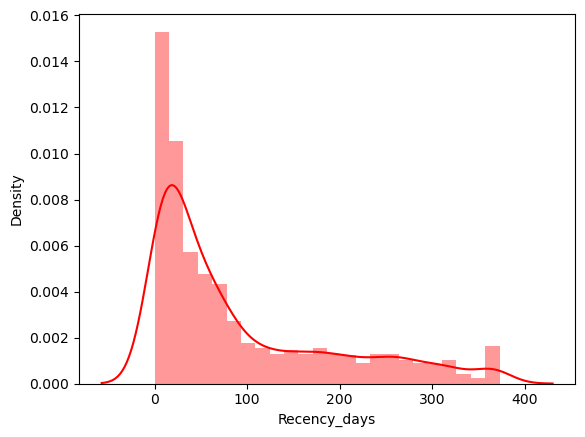

In [29]:
# Plotting the histogram for finding the distributon of the recency, frequency and monetray columns

sns.distplot(cust_rfm["Recency_days"], color='red')

<Axes: xlabel='Frequency', ylabel='Density'>

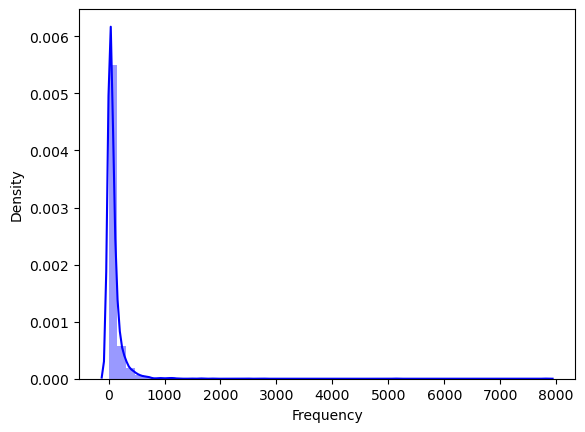

In [30]:
sns.distplot(cust_rfm["Frequency"], color='blue')

<Axes: xlabel='Monetary', ylabel='Density'>

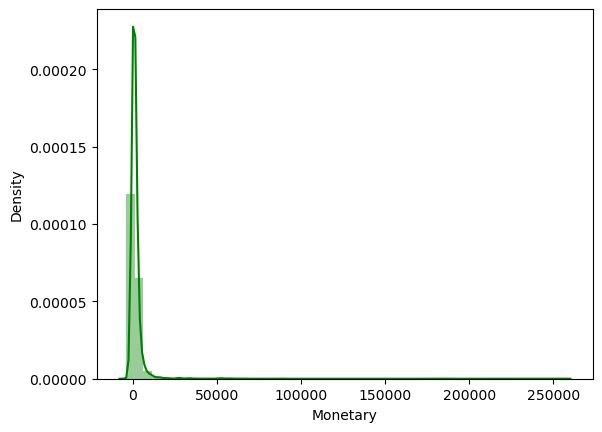

In [31]:
sns.distplot(cust_rfm["Monetary"], color='green')

### All the three distributions are positively skewed distributions with tail extending to right side

In [32]:
#Here, we will divide the data set into 4 parts based on the quartiles range.

Quartile = cust_rfm.drop('CustomerID',axis = 1).quantile(q = [0.25,0.5,0.75])


In [33]:
Quartile.to_dict()

{'Recency_days': {0.25: 16.0, 0.5: 50.0, 0.75: 143.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 281.42, 0.5: 623.3900000000001, 0.75: 1518.43}}

In [34]:
# now we will develop a function for recency
# Lower the value of recency, higher is the value of customer. 

def recency_score(value, q,data):
    if value <= data[q][0.25]:  # for 25th percentile value
        return 1
    elif value <= data[q][0.50]:  # for 50th percentile value
        return 2
    elif value <= data[q][0.75]:   # for 75th percentile value
        return 3
    else:
        return 4

In [35]:
# now for monetary and frequency function
# higher the values, greater is the customer values

def freqmon(value, q,data):
    if value <= data[q][0.25]:
        return 4
    elif value <= data[q][0.50]:
        return 3
    elif value <= data[q][0.75]:
        return 2
    else:
        return 1

In [36]:
# now giving scores to individualcustomers based on the r, f, m functions

cust_rfm['r_score'] = cust_rfm['Recency_days'].apply(recency_score,args = ('Recency_days',Quartile,))
cust_rfm['f_score'] = cust_rfm['Frequency'].apply(freqmon,args = ('Frequency',Quartile,))
cust_rfm['m_score'] = cust_rfm['Monetary'].apply(freqmon,args = ('Monetary',Quartile,))

In [37]:
cust_rfm.tail()

,CustomerID,Recency_days,Frequency,Monetary,r_score,f_score,m_score
3944,18280.0,277,10,180.60,4,4,4
3945,18281.0,180,7,80.82,4,4,4
3946,18282.0,7,13,176.60,1,4,4
3947,18283.0,3,721,2045.53,1,1,1
3948,18287.0,42,70,1837.28,2,2,1


In [38]:
# now we will add the three scoresto give total rfm score

cust_rfm['Total_Score'] = cust_rfm[['r_score','f_score','m_score']].sum(axis = 1)
cust_rfm.head()

,CustomerID,Recency_days,Frequency,Monetary,r_score,f_score,m_score,Total_Score
0,12346.0,325,2,0.00,4,4,4,12
1,12747.0,2,103,4196.01,1,1,1,3
2,12748.0,0,4458,28405.56,1,1,1,3
3,12749.0,3,231,3868.20,1,1,1,3
4,12820.0,3,59,942.34,1,2,2,5


<Axes: xlabel='r_score', ylabel='Count'>

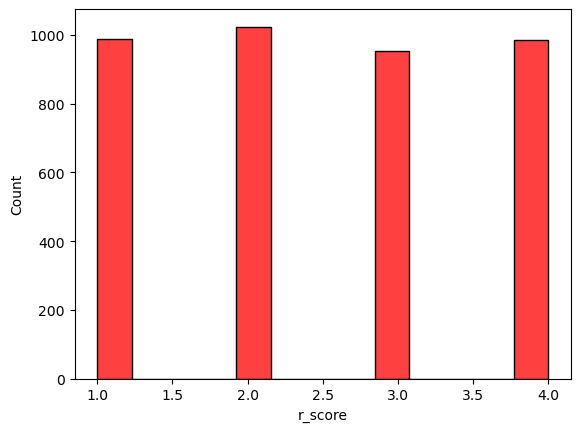

In [39]:
# visualising all the three scores

sns.histplot(cust_rfm['r_score'], color='red')

<Axes: xlabel='f_score', ylabel='Count'>

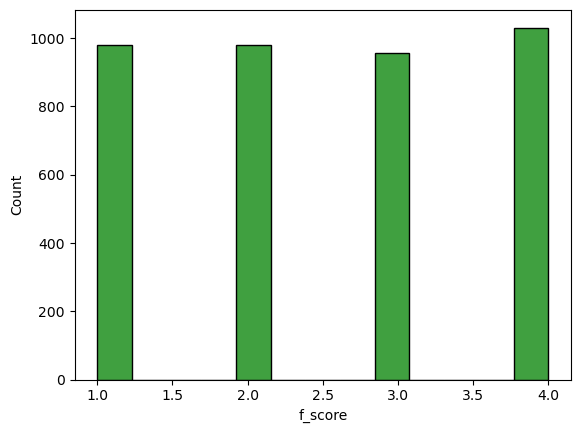

In [40]:
sns.histplot(cust_rfm['f_score'], color='green')

<Axes: xlabel='m_score', ylabel='Count'>

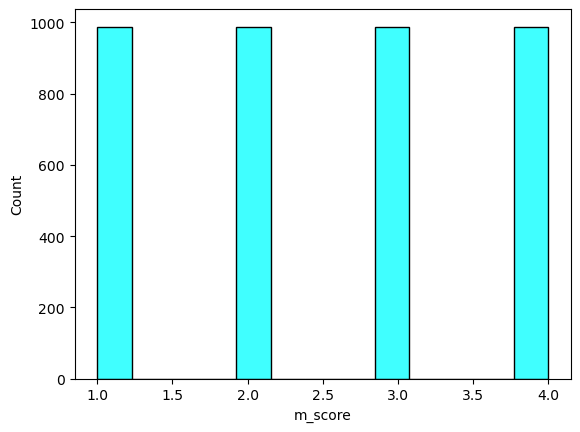

In [41]:
sns.histplot(cust_rfm['m_score'], color='cyan')

<Axes: xlabel='Total_Score', ylabel='Count'>

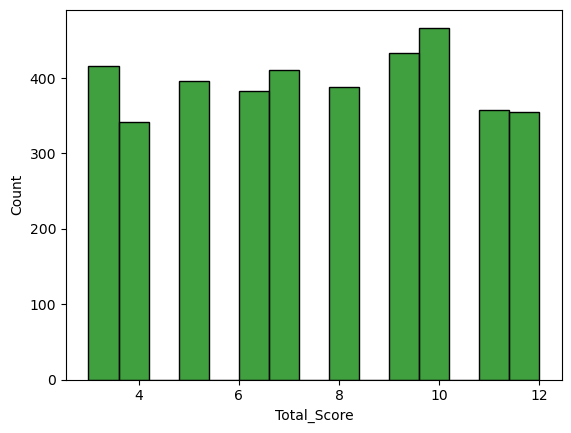

In [42]:
sns.histplot(cust_rfm['Total_Score'], color='green')

In [43]:
# we check for negative values in monetary columns.

cust_rfm[cust_rfm["Monetary"]<0]


,CustomerID,Recency_days,Frequency,Monetary,r_score,f_score,m_score,Total_Score
41,12870.0,366,2,-1.490000e+01,4,4,4,12
92,12943.0,301,1,-3.750000e+00,4,4,4,12
244,13154.0,144,1,-6.118600e+02,4,4,4,12
610,13672.0,301,16,-7.146000e+01,4,4,4,12
623,13693.0,325,4,-3.200000e+01,4,4,4,12
716,13829.0,359,1,-1.020000e+02,4,4,4,12
809,13958.0,372,5,-1.024500e+02,4,4,4,12
926,14119.0,354,1,-1.990000e+01,4,4,4,12
991,14213.0,371,5,-1.192200e+03,4,4,4,12
1148,14437.0,143,6,-4.340000e+01,3,4,4,11


In [44]:
# we treat these negative values
def positive_value(val):
    if val <= 0:
        return 1
    else:
        return val

In [45]:
cust_rfm['Recency_days'] = cust_rfm['Recency_days'].apply(lambda x : positive_value(x))
cust_rfm['Monetary'] = cust_rfm['Monetary'].apply(lambda x : positive_value(x))

### Modeling For Customer segmentation based on the total_score 

In [46]:
# lower the total_score most loyal is the customer
# first we need to standardise the data for r,f,m scores

# checking skewness of the data
cust_rfm.skew()

CustomerID      -0.012348
Recency_days     1.249031
Frequency       18.543072
Monetary        23.349858
r_score          0.024163
f_score         -0.012813
m_score         -0.000408
Total_Score     -0.046270
dtype: float64

In [47]:
# now scaling the data using standardscaler method
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
transform_data=cust_rfm[['Recency_days','Frequency','Monetary']]
Scaled_data = sc.fit_transform(transform_data)
Scaled_data = pd.DataFrame(Scaled_data,columns=transform_data.columns,index=transform_data.index)

In [48]:
Scaled_data

,Recency_days,Frequency,Monetary
0,2.331316,-0.407436,-0.261254
1,-0.891524,0.058455,0.379440
2,-0.901502,20.147099,4.076906
3,-0.881546,0.648890,0.329374
4,-0.881546,-0.144508,-0.117486
...,...,...,...
3944,1.852380,-0.370534,-0.233824
3945,0.884530,-0.384372,-0.249063
3946,-0.841635,-0.356695,-0.234435
3947,-0.881546,2.909151,0.051002


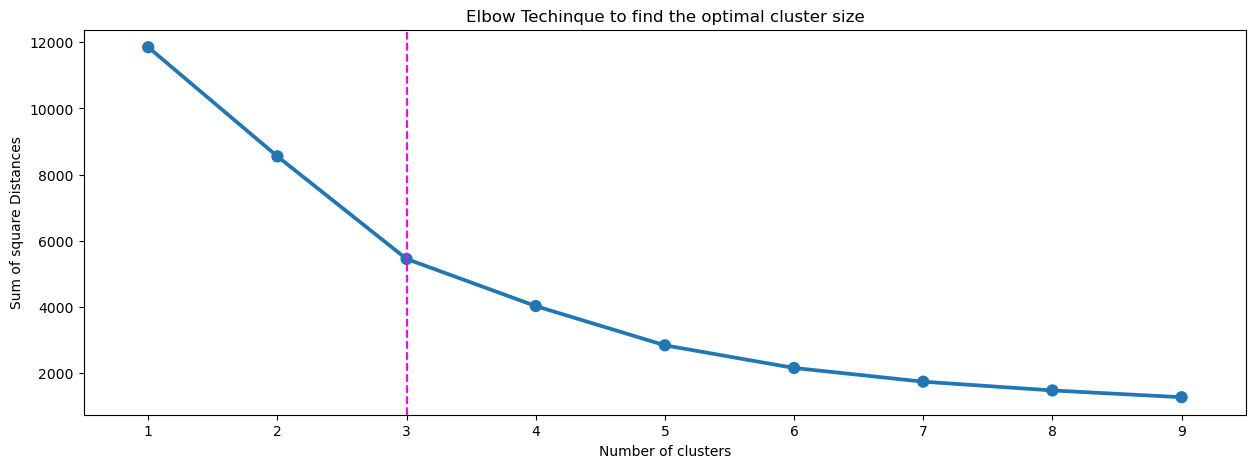

In [49]:
# Will search the optimal number of cluster based on the Elbow Method as below:
SS_distance = {}
for k in range(1,10):
    mode = KMeans(n_clusters= k, max_iter=100,init = 'k-means++', random_state=10)
    mode = mode.fit(Scaled_data)
    SS_distance[k] = mode.inertia_

#Plotting the sum of square distance values and numbers of clusters
plt.figure(figsize = (15,5))
sns.pointplot(x = list(SS_distance.keys()), y = list(SS_distance.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of square Distances")
plt.title("Elbow Techinque to find the optimal cluster size")
plt.axvline(2, 0, 1, label='Elbow point ', color='magenta',ls='--' )
plt.show()

In [50]:
# as per our observation, sum of square distances are decreasing rapidly at k=3, so we choose 3 as optimal values for clusters

In [51]:

KNN = KMeans(n_clusters= 4, init = 'k-means++',max_iter = 100)
KNN.fit(Scaled_data)

# Mapping on the dataset 

cust_rfm['Cluster'] = KNN.labels_
#cust_rfm['Cluster'] = 'Cluster' + cust_rfm['Cluster'].astype(str)
cust_rfm.head()

,CustomerID,Recency_days,Frequency,Monetary,r_score,f_score,m_score,Total_Score,Cluster
0,12346.0,325,2,1.00,4,4,4,12,0
1,12747.0,2,103,4196.01,1,1,1,3,2
2,12748.0,1,4458,28405.56,1,1,1,3,1
3,12749.0,3,231,3868.20,1,1,1,3,2
4,12820.0,3,59,942.34,1,2,2,5,2


In [52]:
cust_rfm["Cluster"].value_counts()

2    2935
0    1004
1       8
3       2
Name: Cluster, dtype: int64

In [53]:
label_df=cust_rfm[['r_score','f_score','m_score', 'Total_Score', 'Cluster']]

In [54]:
label_df

,r_score,f_score,m_score,Total_Score,Cluster
0,4,4,4,12,0
1,1,1,1,3,2
2,1,1,1,3,1
3,1,1,1,3,2
4,1,2,2,5,2
...,...,...,...,...,...
3944,4,4,4,12,0
3945,4,4,4,12,0
3946,1,4,4,9,2
3947,1,1,1,3,2


In [55]:
label_0 = label_df[KNN.labels_ == 0]
label_1 = label_df[KNN.labels_== 1]
label_2 = label_df[KNN.labels_ == 2]

<Figure size 700x700 with 0 Axes>

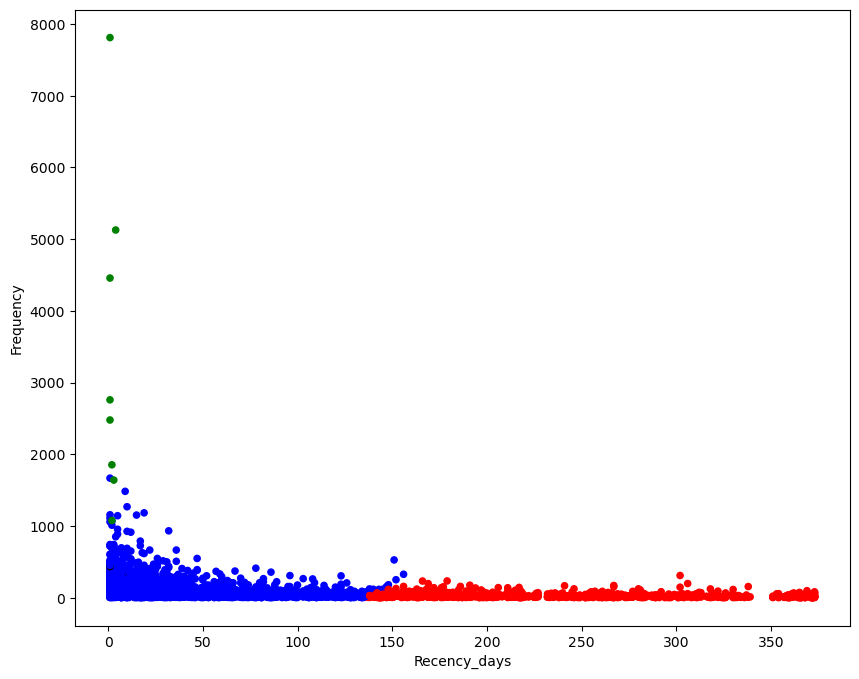

In [56]:
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue", "black"]
cust_rfm['Color'] = cust_rfm['Cluster'].map(lambda p: Colors[p])
ax = cust_rfm.plot(    
    kind="scatter", 
    x="Recency_days", y="Frequency",
    figsize=(10,8),
    c = cust_rfm['Color']
)

### The recency, frequency, monetary value (RFM) model assigns a firm’s customer base a particular trait, which can be used to improve marketing analysis. 

### :- Red points marks the most loyal customers 